In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-yjx0ggwd
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-yjx0ggwd
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=654e3e5528a651691b48705109e640a5136d7db7d7ffde8bcf3f35997e216a3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-txsljao3/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-80obm_y2
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-80obm_y2
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=1b948b3c6b8dda2ee8ccf18175d49183256a5f2ffd43ba90fa41a65992b8d3c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-0g1pojdx/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyTorchTemplate as ptt

In [5]:
print(ptt.__file__)

/global/homes/k/khwang/.local/cori/pytorchv1.4.0/lib/python3.7/site-packages/pyTorchTemplate/__init__.py


$$
\begin{eqnarray}
\boldsymbol{R} &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi \boldsymbol{R})}{4\pi\boldsymbol{R}}
\end{eqnarray}
$$

In [6]:
ndim = 6
nSample = 2048*100

In [7]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

# Prepare data

In [8]:
x_train = ((np.random.rand(nSample,ndim)-0.5)*2).astype(np.float32)
y_train = f(x_train).reshape(-1,1).astype(np.float32)

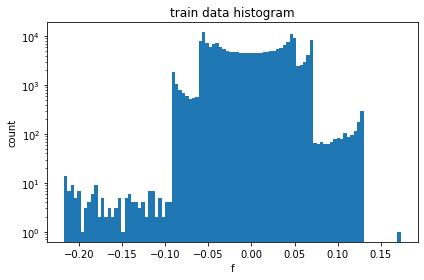

In [9]:
hist = plt.hist(y_train,bins=100);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram')
# plt.xlim(yPrior_train.min(),yPrior_train.max())
plt.yscale('log')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(ndim)+'D_'+str(nSample)+'sample.png',dpi=180)

In [10]:
x_onAxis = np.zeros([256,ndim]).astype(np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 256)
y_onAxis = f(x_onAxis).reshape(-1,1).astype(np.float32)

In [11]:
train_data_loader = torch.utils.data.DataLoader(list(zip(x_train,y_train)),batch_size=128*100)

In [12]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

# MPELoss p=8

In [29]:
p=8

In [30]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN([ndim,128,128,1], torch.nn.CELU(inplace=True))
  mode,hist = ptt.train_supervised(model,1.0e-2,10,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,70,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,80,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
                                criterion=ptt.MPELoss(p=p),
                                old_hist = hist,
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

7.084867519324689e-06


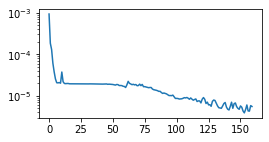

In [31]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [32]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.03734249],
       [ 0.04163471],
       [-0.05028855],
       [ 0.00300062],
       [ 0.07597534],
       [-0.01890351],
       [ 0.07219861],
       [ 0.0723442 ],
       [-0.05145625],
       [ 0.07147273]], dtype=float32)

In [33]:
f(x_train[:10,:])

array([ 0.04615494,  0.04104045, -0.03910502, -0.02198161,  0.06877586,
       -0.02320998,  0.06014055,  0.06443206, -0.05419169,  0.07079376],
      dtype=float32)

In [34]:
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

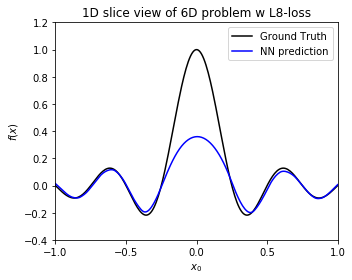

In [35]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'b', label='NN prediction')

plt.title('1D slice view of '+str(ndim)+'D problem w L'+str(p)+'-loss')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('NN_'+str(ndim)+'D_L'+str(p)+'-Loss.png',dpi=180)

In [36]:
ptt.count_parameters(model)

179874

# MPELoss p=4

In [37]:
p=4

In [38]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN([ndim,128,128,1], torch.nn.CELU(inplace=True))
  mode,hist = ptt.train_supervised(model,1.0e-2,10,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,70,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,80,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
                                criterion=ptt.MPELoss(p=p),
                                old_hist = hist,
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

4.365067070466466e-05


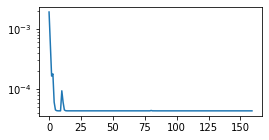

In [39]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [40]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 3.4368783e-04],
       [ 4.6499074e-04],
       [-6.7710876e-05],
       [-1.6605854e-04],
       [-1.5545264e-04],
       [ 1.6795099e-04],
       [-4.9702823e-05],
       [ 5.5902824e-04],
       [ 9.2539936e-04],
       [ 1.6616210e-03]], dtype=float32)

In [41]:
f(x_train[:10,:])

array([ 0.04615494,  0.04104045, -0.03910502, -0.02198161,  0.06877586,
       -0.02320998,  0.06014055,  0.06443206, -0.05419169,  0.07079376],
      dtype=float32)

In [42]:
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

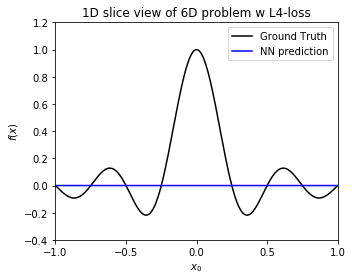

In [43]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'b', label='NN prediction')

plt.title('1D slice view of '+str(ndim)+'D problem w L'+str(p)+'-loss')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('NN_'+str(ndim)+'D_L'+str(p)+'-Loss.png',dpi=180)

In [44]:
ptt.count_parameters(model)

179874

# MPELoss p=2

In [45]:
p=2

In [46]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN([ndim,128,128,1], torch.nn.CELU(inplace=True))
  mode,hist = ptt.train_supervised(model,1.0e-2,10,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  tmp = test(model,ptt.MPELoss(p=p),train_data_loader)
  if tmp > 1:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,70,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-3:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,80,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
                                criterion=ptt.MPELoss(p=p),
                                old_hist = hist,
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

2.522961847262195e-05


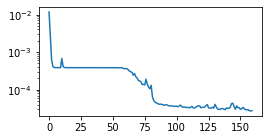

In [47]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [48]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[ 0.04614731],
       [ 0.03974257],
       [-0.03913914],
       [-0.02013812],
       [ 0.06922635],
       [-0.02765425],
       [ 0.05914068],
       [ 0.06591163],
       [-0.05312545],
       [ 0.07037163]], dtype=float32)

In [49]:
f(x_train[:10,:])

array([ 0.04615494,  0.04104045, -0.03910502, -0.02198161,  0.06877586,
       -0.02320998,  0.06014055,  0.06443206, -0.05419169,  0.07079376],
      dtype=float32)

In [50]:
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

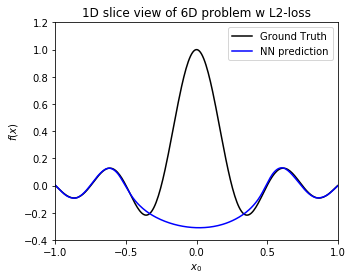

In [51]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'b', label='NN prediction')

plt.title('1D slice view of '+str(ndim)+'D problem w L'+str(p)+'-loss')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('NN_'+str(ndim)+'D_L'+str(p)+'-Loss.png',dpi=180)

In [52]:
ptt.count_parameters(model)

179874